## Importing modules

In [35]:
import matplotlib.pyplot as plt
import nilearn.image as image
from nilearn.image import resample_to_img
from nilearn import datasets
from nilearn.maskers import NiftiMasker
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_img, plot_anat, plot_stat_map, plot_roi, plot_design_matrix, plot_contrast_matrix, view_img
import numpy as np
import os
import glob
import nibabel as nib
import pandas as pd
from pathlib import Path
import tracemalloc

## Defining global variables

In [37]:
path_data = '/data/rainville/PAINxEFFORT/PREPROCESSED_SPM'
path_events = '/scratch/mepicard/pain_effort/'
path_mask = "/scratch/mepicard/pain_effort/derivatives/resampled_gm_group_mask.nii"
path_output = "/scratch/mepicard/pain_effort/derivatives/"

sub = "sub-008"

t_r = 0.832

## Example for one participant - run level

### Loading data

In [6]:
# Load mask
mask = nib.load(path_mask)

In [7]:
# Events file path
events = [os.path.join(path_events, sub, e) for e in os.listdir(os.path.join(path_events, sub)) if "events" in e]
events.sort()

In [8]:
events

['/scratch/mepicard/pain_effort/sub-008/P8_events_run1.xlsx',
 '/scratch/mepicard/pain_effort/sub-008/P8_events_run2.xlsx',
 '/scratch/mepicard/pain_effort/sub-008/P8_events_run3.xlsx',
 '/scratch/mepicard/pain_effort/sub-008/P8_events_run4.xlsx']

In [9]:
events = [pd.read_excel(e) for e in events]

In [10]:
# Bold path
bold = [os.path.join(path_data,sub,"func",b) for b in os.listdir(os.path.join(path_data, sub ,"func")) if "swvrsub" in b]
bold.sort()

In [11]:
bold

['/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-01_bold.nii',
 '/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-02_bold.nii',
 '/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-03_bold.nii',
 '/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-04_bold.nii']

In [12]:
# Make sure the number of bold files matches the number of event files
if len(events) == len(bold):
    print("Right number of files found !")
else:
    print("Mismatch between the number of event files and the number of bold files")

Right number of files found !


In [13]:
# Specify the column names explicitly
#event_types = events['your_trial_type_column']
#onsets = events['your_onset_column']
#durations = events['your_duration_column']

### Running the first level model

In [14]:
first_level_model = FirstLevelModel(t_r, mask_img=mask)

In [15]:
# Fit the model
tracemalloc.start()
glm_run_1 = first_level_model.fit(bold[1], events=events[1])
print(tracemalloc.get_traced_memory())
tracemalloc.stop()

(54635866, 7635065060)


In [16]:
# in bytes : 7635065386
# 1 GB = 1,000,000,000 bytes
print(f"Memory usage: {7635065386/1000000000} GiB")

Memory usage: 7.635065386 GiB


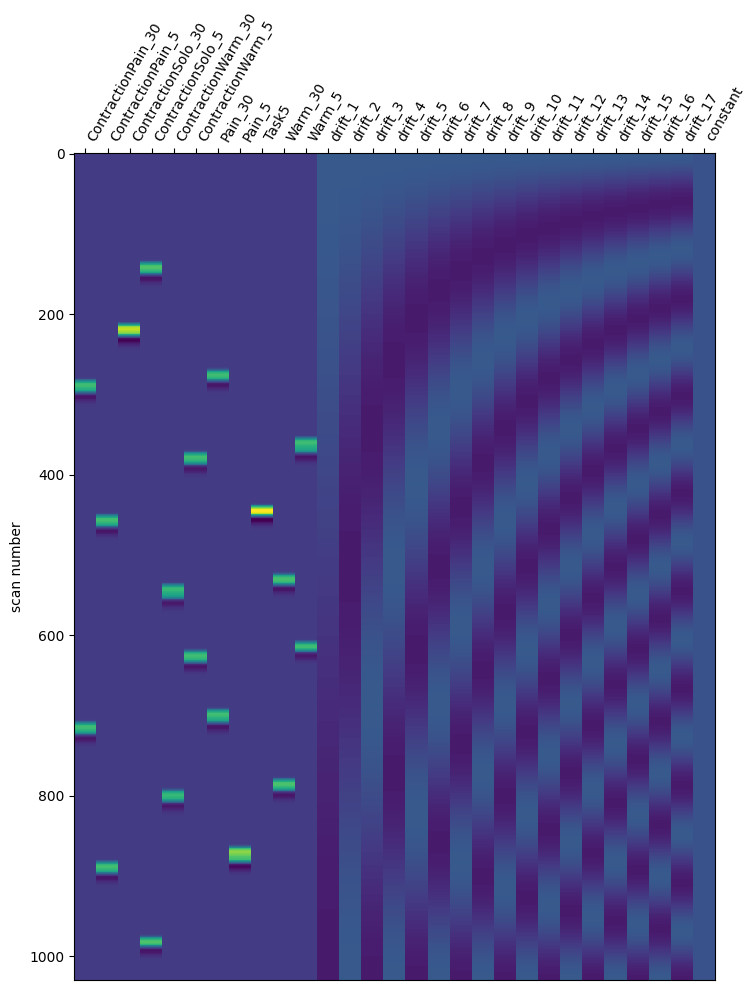

In [19]:
# Plot the design matrix
plot_design_matrix(glm_run_1.design_matrices_[0])
plt.show()

### Defining the contrasts

In [46]:
def make_localizer_contrasts(design_matrix):
    """Return a dictionary of four contrasts, given the design matrix."""
    # first generate canonical contrasts
       
    contrast_matrix_run1 = np.eye(design_matrix.shape[1])
    
    contrasts = {
        column: contrast_matrix_run1[i]
        for i, column in enumerate(design_matrix.columns)
    }

    contrasts["pain"] = (
        contrasts["Pain_30"]
        + contrasts["Pain_5"]
    )

    # one contrast adding all conditions involving warm
    contrasts["warm"] = (
        contrasts["Warm_30"]
        + contrasts["Warm_5"]
    )

    # one contrast adding all conditions involving contraction at 5%
    contrasts["contraction_5"] = (
        contrasts["ContractionSolo_5"] + contrasts["ContractionWarm_5"] + contrasts["ContractionPain_5"]
    )

    # one contrast adding all conditions involving contraction at 30%
    contrasts["contraction_30"] = (
        contrasts["ContractionSolo_30"] + contrasts["ContractionWarm_30"] + contrasts["ContractionPain_30"]
    )

       # one contrast adding all conditions involving contraction during warm
    contrasts["contraction_warm"] = (
        contrasts["ContractionWarm_30"] + contrasts["ContractionWarm_5"]
    )
    
    
          # one contrast adding all conditions involving contraction during pain
    contrasts["contraction_pain"] = (
        contrasts["ContractionPain_30"] + contrasts["ContractionPain_5"]
    )
    

    # Short dictionary of more relevant contrasts
    contrasts = {
        "pain - warm": (
            contrasts["pain"]
            - contrasts["warm"]
        ),
        "contraction 30%-5%": contrasts["contraction_30"] - contrasts["contraction_5"],
        "contraction Warm-Pain": (
            contrasts["contraction_pain"] - contrasts["contraction_warm"]
        ),
        "contraction 5%_pain - warm": (
            contrasts["ContractionPain_5"]
            - contrasts["ContractionWarm_5"]
        ),
        "contraction 30%_pain - warm": (
            contrasts["ContractionPain_30"]
            - contrasts["ContractionWarm_30"]
        ),
         "contraction pain_30% - 5%": (
            contrasts["ContractionPain_30"]
            - contrasts["ContractionPain_5"]
        ),
         "contractionSolo 30%-5%": (
            contrasts["ContractionSolo_30"]
            - contrasts["ContractionSolo_5"]
        ),
    }
    return contrasts

In [22]:
#  list of design matrices for each run
design_matrices = glm_run_1.design_matrices_[0]

# Call the function to generate contrasts for all runs
localizer_contrasts = make_localizer_contrasts(design_matrices)

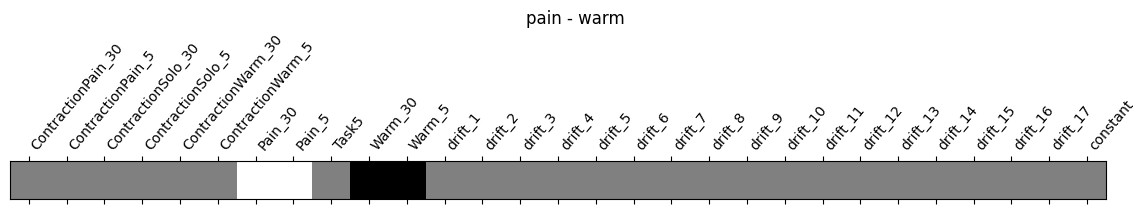

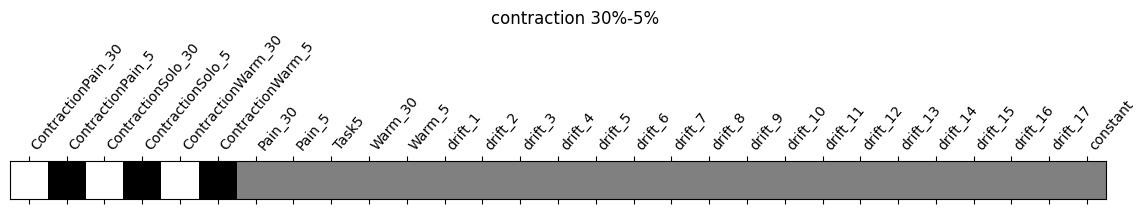

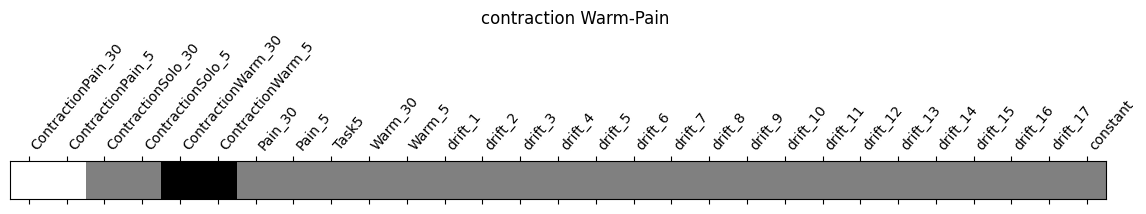

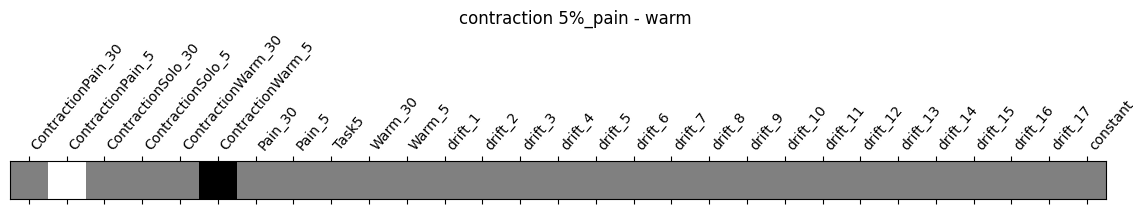

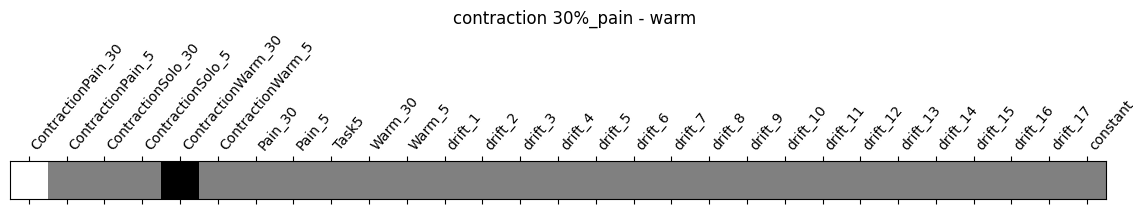

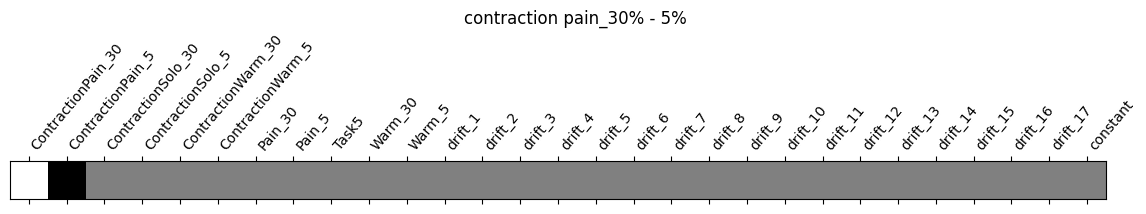

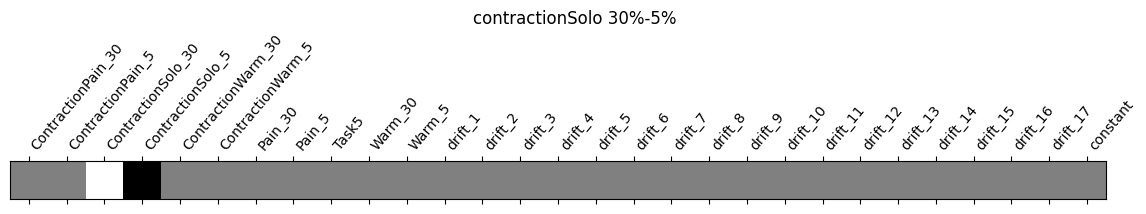

In [23]:
# Choose a specific design matrix from the list
design_matrix_to_visualize = design_matrices

for key, values in localizer_contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrix_to_visualize)
    plt.suptitle(key)

plt.show()

### Generating the activation map

In [39]:
beta_map = glm_run_1.compute_contrast(localizer_contrasts['pain - warm'], output_type='effect_size')

### Visualizing the activation map

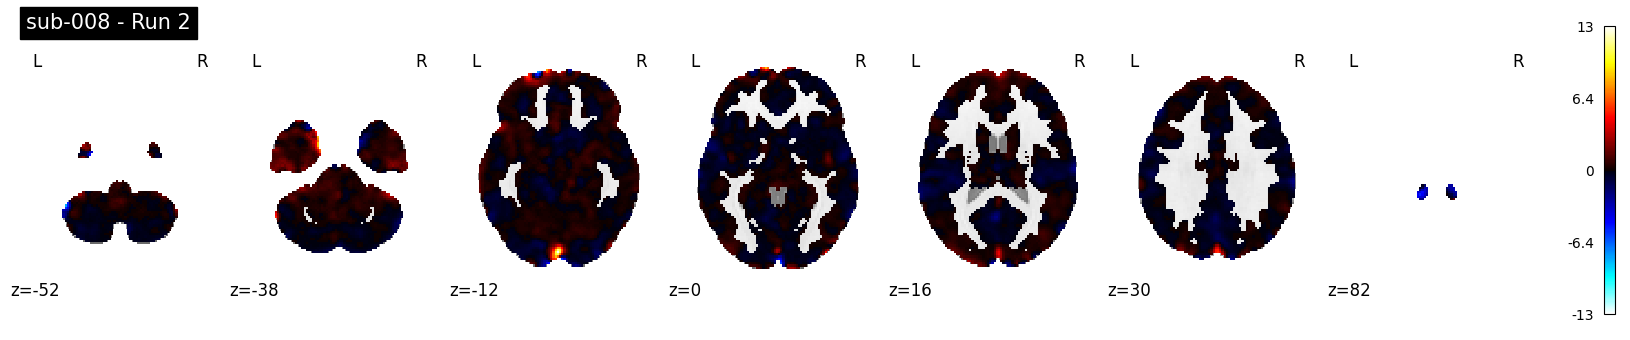

In [44]:
plot_stat_map(
    beta_map,
    display_mode="z",
    title=f"{sub} - Run 2",
)

In [44]:
def run_first_level_trial(path_data, path_events, path_mask, path_output, sub, t_r=0.832, contrasts=['pain - warm', 'contraction 30%-5%', 'contractionSolo 30%-5%']):
    """
    Parameters
    ----------
    path_data: str
        Directory containing the bold files
    path_events: str
        Directory containing the event files
    path_mask: str
        Path to the group mask
    path_output: str
        Outputs path
    sub: str
        Subject id
    t_r: float
        Repetition time
    """
    # Create output path if doesn't exit
    Path(path_output, sub).mkdir(parents=True, exist_ok=True)
    # Load mask
    mask = nib.load(path_mask)
    # Events files
    events = [os.path.join(path_events, sub, e) for e in os.listdir(os.path.join(path_events, sub)) if "events" in e]
    events.sort()
    print(events)
    events = [pd.read_excel(e) for e in events]
    
    # Bold path
    bolds = [os.path.join(path_data,sub,"func",b) for b in os.listdir(os.path.join(path_data, sub ,"func")) if "swvrsub" in b]
    bolds.sort()
    print(bolds)

    dict_trials = {}

    for idx, (event, bold) in enumerate(zip(events, bolds), start=1):
        filename = "_".join(bold.split("/")[-1].split("_")[:-1])
        
        # Define model
        first_level_model = FirstLevelModel(t_r, mask_img=mask)
        # Fit the model
        fmri_glm = first_level_model.fit(bold, events=event)
    
        #  list of design matrices for each run
        design_matrices = fmri_glm.design_matrices_
        design_matrices[0].to_csv(os.path.join(path_output, sub, filename+"_desc-design_matrices.tsv.gz"))
            
        # Call the function to generate contrasts for all runs
        localizer_contrasts = []
        for design_matrix in fmri_glm.design_matrices_:
            localizer_contrasts.append(make_localizer_contrasts(design_matrix))
    
        # Compute the contrasts
        dict_maps = {}
        for contrast in contrasts:
            localizer_contrast = [i[contrast] for i in localizer_contrasts]
            beta_map = fmri_glm.compute_contrast(localizer_contrast, output_type='effect_size')
            nib.save(beta_map, os.path.join(path_output, sub, filename+f'_desc-{contrast}-maps.nii.gz'))
            dict_maps[contrast] = beta_map
        dict_trials[f"run-0{idx}"] = dict_maps
    return dict_trials

In [47]:
dict_sub008 = run_first_level_trial(path_data, path_events, path_mask, path_output, sub, t_r=0.832, contrasts=['pain - warm', 'contraction 30%-5%', 'contractionSolo 30%-5%'])

['/scratch/mepicard/pain_effort/sub-008/P8_events_run1.xlsx', '/scratch/mepicard/pain_effort/sub-008/P8_events_run2.xlsx', '/scratch/mepicard/pain_effort/sub-008/P8_events_run3.xlsx', '/scratch/mepicard/pain_effort/sub-008/P8_events_run4.xlsx']
['/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-01_bold.nii', '/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-02_bold.nii', '/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-03_bold.nii', '/data/rainville/PAINxEFFORT/PREPROCESSED_SPM/sub-008/func/swvrsub-008_task-pain_run-04_bold.nii']


/home/mepicard/.virtualenvs/pain_effort_env/lib/python3.10/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


{'run-01': {'pain - warm': <nibabel.nifti1.Nifti1Image at 0x7fe1a8f03010>,
  'contraction 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe137e59270>,
  'contractionSolo 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe13795cac0>},
 'run-02': {'pain - warm': <nibabel.nifti1.Nifti1Image at 0x7fe137fe6380>,
  'contraction 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe137f0ea70>,
  'contractionSolo 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe13795d660>},
 'run-03': {'pain - warm': <nibabel.nifti1.Nifti1Image at 0x7fe137671240>,
  'contraction 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe1376af700>,
  'contractionSolo 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe13737cca0>},
 'run-04': {'pain - warm': <nibabel.nifti1.Nifti1Image at 0x7fe137eb2260>,
  'contraction 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe137b66170>,
  'contractionSolo 30%-5%': <nibabel.nifti1.Nifti1Image at 0x7fe137eb1ae0>}}

## Example for one participant - participant level

We will basically repeat what we did above for all runs. Just going to re-write the code inside functions to iterate over runs

In [26]:
def run_first_level_participant(path_data, path_events, path_mask, sub, t_r=0.832, contrasts=['pain - warm']):
    """
    Parameters
    ----------
    path_data: str
        Directory containing the bold files
    path_events: str
        Directory containing the event files
    path_mask: str
        Path to the group mask
    sub: str
        Subject id
    t_r: float
        Repetition time
    """
    tracemalloc.start()
    # Load mask
    mask = nib.load(path_mask)
    # Events files
    events = [os.path.join(path_events, sub, e) for e in os.listdir(os.path.join(path_events, sub)) if "events" in e]
    events.sort()
    events = [pd.read_excel(e) for e in events]
    
    # Bold path
    bolds = [os.path.join(path_data,sub,"func",b) for b in os.listdir(os.path.join(path_data, sub ,"func")) if "swvrsub" in b]
    bolds.sort()
    print(f"Memory usage for loading data: {tracemalloc.get_traced_memory()}")

    # Define model
    first_level_model = FirstLevelModel(t_r, mask_img=mask)
    # Fit the model
    fmri_glm = first_level_model.fit(bolds, events=events)
    print(f"Memory usage for model fitting: {tracemalloc.get_traced_memory()}")

    #  list of design matrices for each run
    design_matrices = fmri_glm.design_matrices_

    plot_design_matrix(fmri_glm.design_matrices_[0])
    plt.show()
        
    # Call the function to generate contrasts for all runs
    localizer_contrasts = []
    for design_matrix in fmri_glm.design_matrices_:
        localizer_contrasts.append(make_localizer_contrasts(design_matrix))

    # Compute the contrasts
    dict_maps = {}
    for contrast in contrasts:
        localizer_contrast = [i[contrast] for i in localizer_contrasts]
        beta_map = fmri_glm.compute_contrast(localizer_contrast, output_type='effect_size')
        dict_maps[contrast] = beta_map
    print(f"Memory usage for computing contrast: {tracemalloc.get_traced_memory()}")
    tracemalloc.stop()
    
    return dict_maps

Memory usage for loading data: (265343, 435012)


/home/mepicard/.virtualenvs/pain_effort_env/lib/python3.10/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


Memory usage for model fitting: (211934866, 7792491635)


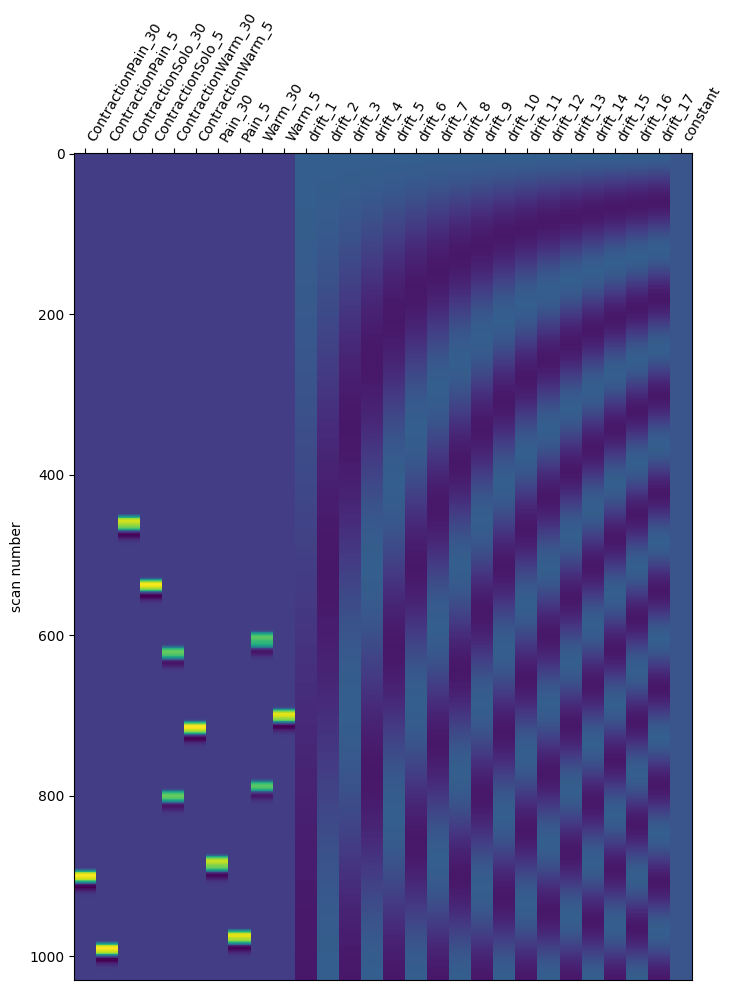

Memory usage for computing contrast: (226613939, 7792491635)


In [27]:
contrast_maps = run_first_level_participant(path_data, path_events, path_mask, sub, t_r=0.832, contrasts=['pain - warm', 'contraction 30%_pain - warm'])

In [33]:
localizer_contrasts

[{'pain - warm': array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1., -1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]),
  'contraction 30%-5%': array([ 1., -1.,  1., -1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]),
  'contraction Warm-Pain': array([ 1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]),
  'contraction 5%_pain - warm': array([ 0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]),
  'contraction 30%_pain - warm': array([ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]),
  'contraction pain_30% - 5%': a

C:\Users\ilari\AppData\Roaming\Python\Python39\site-packages\nilearn\plotting\matrix_plotting.py:352: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(.4 * len(design_column_names),


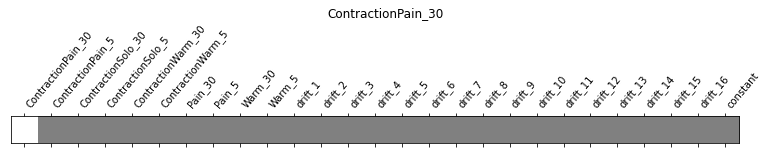

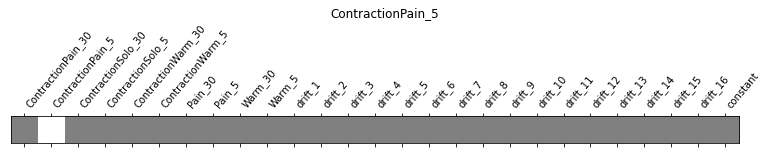

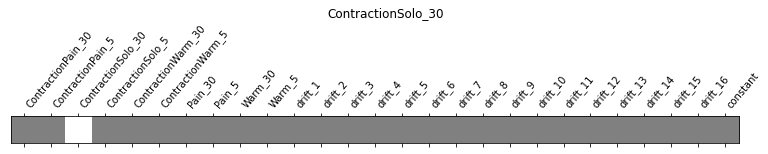

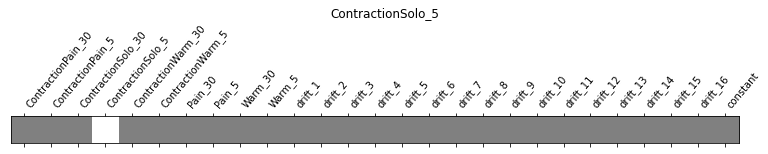

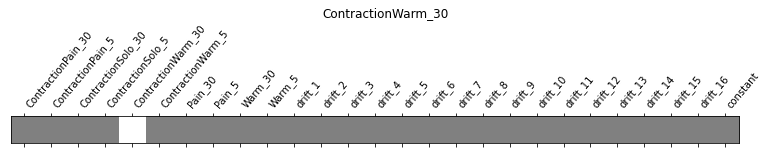

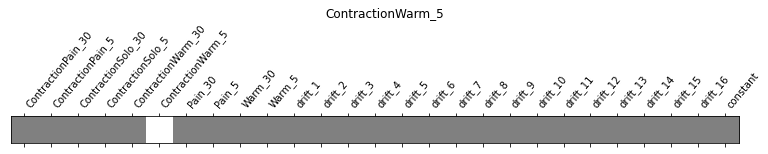

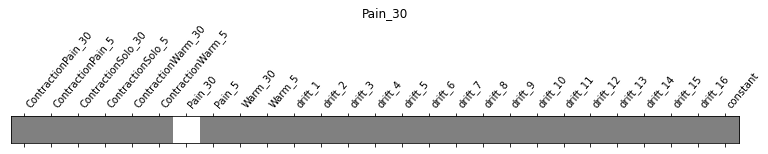

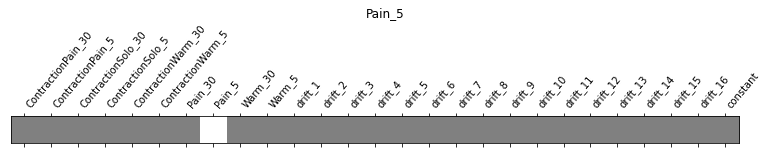

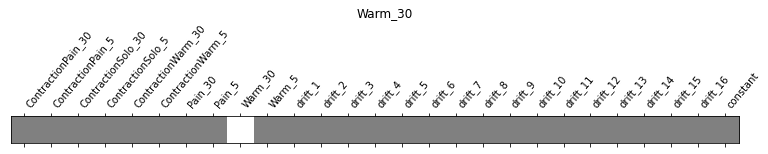

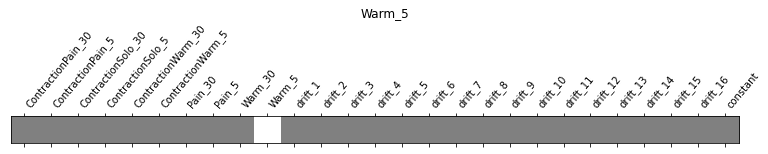

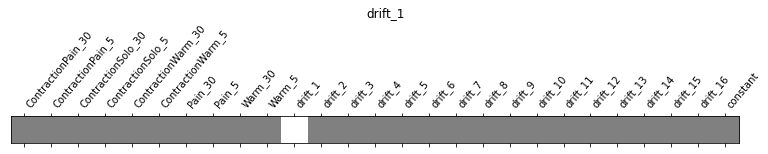

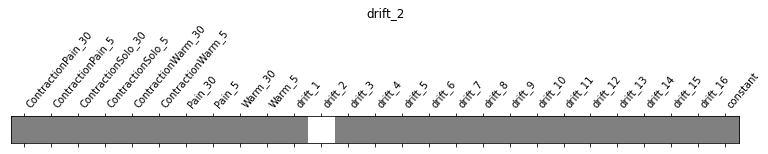

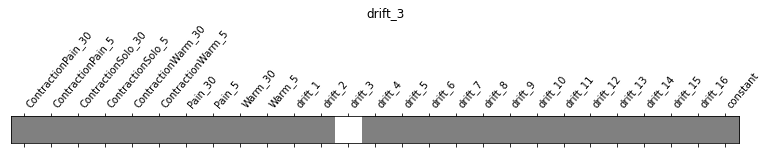

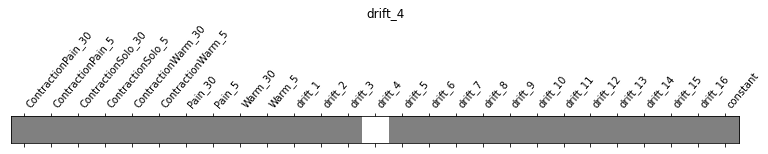

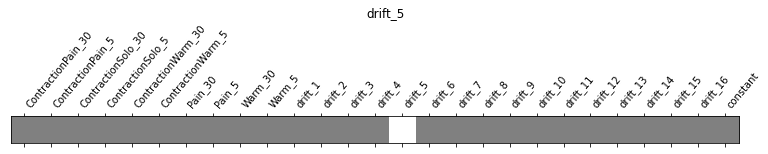

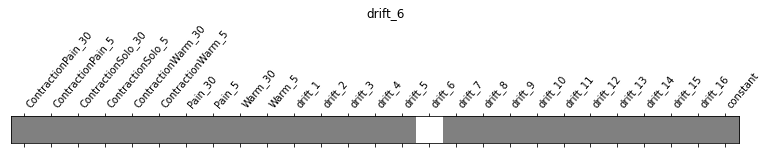

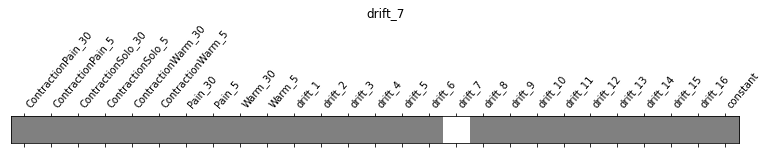

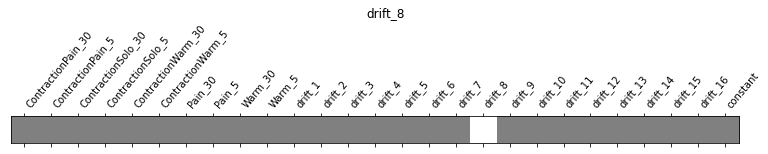

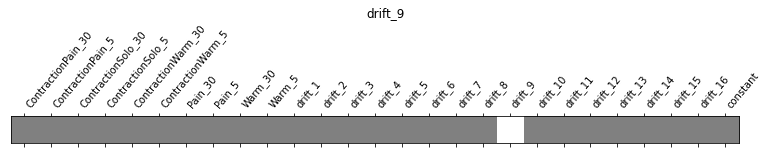

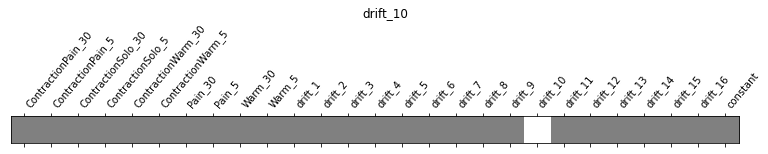

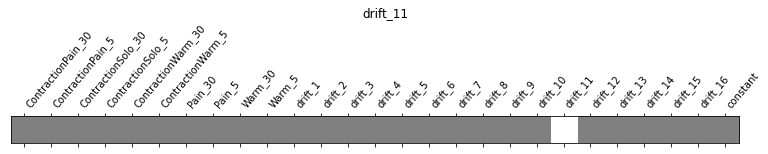

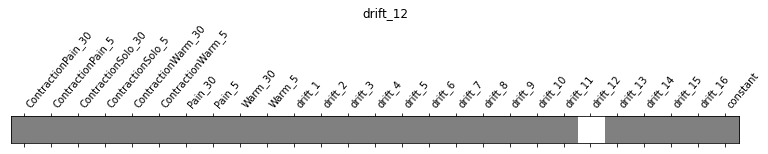

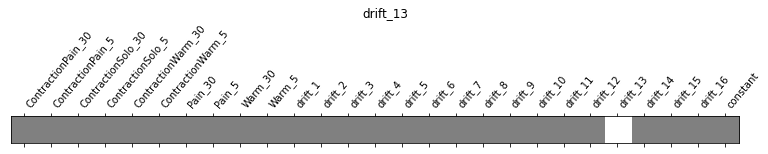

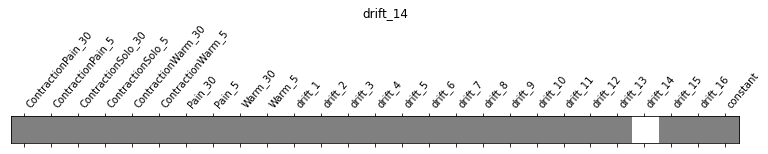

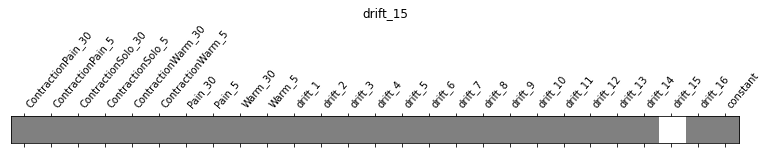

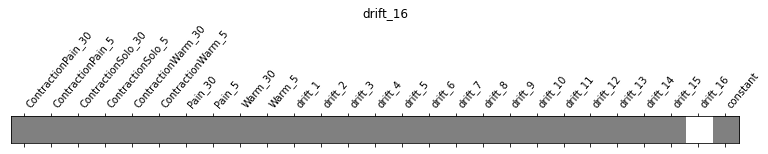

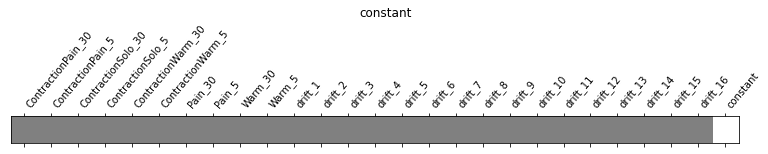

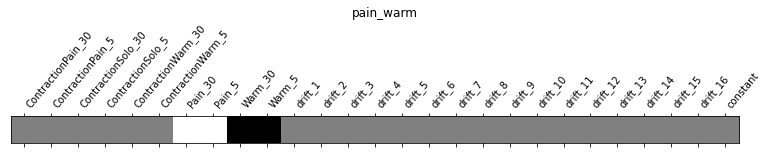

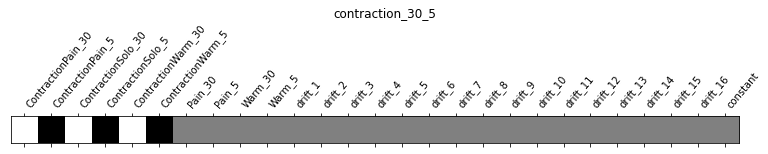

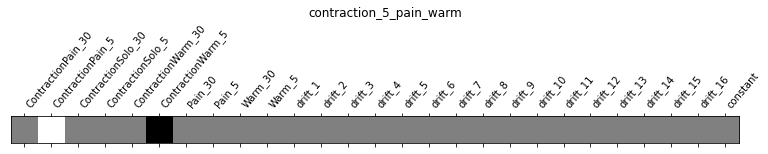

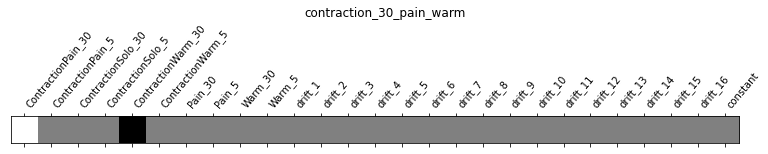

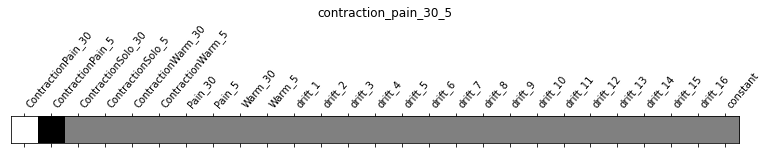

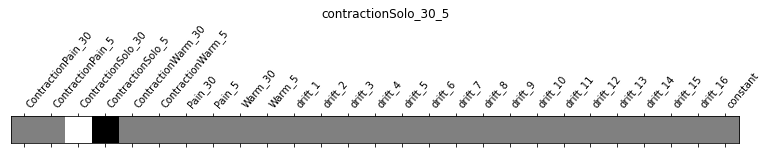

In [40]:
from nilearn.plotting import plot_contrast_matrix

# Choose a specific design matrix from the list
design_matrix_to_visualize = design_matrices[0]

for key, values in localizer_contrasts_example.items():
    plot_contrast_matrix(values, design_matrix=design_matrix_to_visualize)
    plt.suptitle(key)

plt.show()

In [121]:
#from nilearn.plotting import plot_contrast_matrix

#contrasts = make_localizer_contrasts(design_matrix)

#for key, values in contrasts.items():
    #plot_contrast_matrix(values, design_matrix=design_matrix)
    #plt.suptitle(key)

#plt.show()

In [44]:
for run_idx, first_level_model_run in enumerate(first_level_model, start=1):
    print(f"Run {run_idx} - Number of parameters: {len(first_level_model_run.labels_)}")


Run 1 - Number of parameters: 1
Run 2 - Number of parameters: 1
Run 3 - Number of parameters: 1
Run 4 - Number of parameters: 1


ValueError: t contrasts should be length P=28, but this is length 27

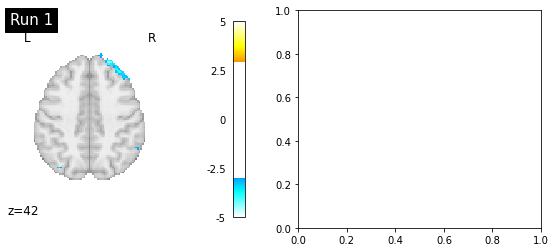

In [45]:
from nilearn import plotting

def plot_contrast_for_runs(first_level_models, desired_contrast, design_matrices):
    """Plot z-maps for a specific contrast across different runs."""
    
    plt.figure(figsize=(20, 4))
    
    for run_idx, (first_level_model, design_matrix_run) in enumerate(zip(first_level_models, design_matrices), start=1):
        ax = plt.subplot(1, len(first_level_models), run_idx)
        
        # Compute the per-contrast z-map for the current run
        z_map = first_level_model.compute_contrast(desired_contrast, output_type="z_score")
        
        # Plot the z-map
        plotting.plot_stat_map(
            z_map,
            display_mode="z",
            threshold=3.0,
            title=f"Run {run_idx}",
            axes=ax,
            cut_coords=1,
        )

    plt.show()

# Convert first_level_model to a list if it's not already
first_level_model = [first_level_model_run1, first_level_model_run2, first_level_model_run3, first_level_model_run4]

design_matrices_example = [design_matrix_run1, design_matrix_run2, design_matrix_run3, design_matrix_run4]
desired_contrast = localizer_contrasts_example["contraction_30_5"]

# Call the modified plot_contrast_for_runs function
plot_contrast_for_runs(first_level_model, desired_contrast, design_matrices_example)

    
    